# What can we find out about the introduction of brand new products?

The SQL below is saved as a view in BigQuery. It finds all products that currently have prescribing of over 1000 items per month, that were introduced in the last 5 years, per no more recently than 6 months ago.

In [1]:
import pandas as pd
import os

In [2]:
if not os.path.exists('new_chemicals.csv'):
    sql = """WITH
      chemicals AS (
      SELECT
        month,
        DATE_SUB(
      DATE(
        EXTRACT(YEAR FROM CURRENT_DATE()), 
        EXTRACT(MONTH FROM CURRENT_DATE()), 
        1), 
      INTERVAL 5 YEAR) AS start_month, 
        SUBSTR(bnf_code, 1, 9) AS chemical,
        SUM(items) AS items
      FROM
        `ebmdatalab.hscic.normalised_prescribing_standard` rx
      WHERE
        DATE(month) >= DATE_SUB(
      DATE(
        EXTRACT(YEAR FROM CURRENT_DATE()), 
        EXTRACT(MONTH FROM CURRENT_DATE()), 
        1), 
      INTERVAL 5 YEAR) 
        AND DATE(month) <= DATE_SUB(
      DATE(
        EXTRACT(YEAR FROM CURRENT_DATE()), 
        EXTRACT(MONTH FROM CURRENT_DATE()), 
        1), 
      INTERVAL 6 MONTH) -- give it six months
        AND bnf_code not like '2%' -- exclude devices
      GROUP BY
        month,
        chemical,
        SUBSTR(bnf_code, 1, 9)),
      base_month AS (
      SELECT
        chemical,
        start_month,
        month,
        items,
        RANK() OVER (PARTITION BY chemical ORDER BY month) + 1 AS rank
      FROM
        chemicals),
      base_month_offset AS (
      SELECT
        chemical,
        month,
        start_month,
        items,
        RANK() OVER (PARTITION BY chemical ORDER BY month) AS rank
      FROM
        chemicals),
      new_chemicals AS (
      SELECT
        base_month_offset.*
      FROM
        base_month_offset
      LEFT JOIN
        base_month
      ON
        base_month.rank = base_month_offset.rank
        AND base_month.chemical = base_month_offset.chemical
      WHERE
        base_month.chemical IS NULL
      ORDER BY
        base_month_offset.month )
    SELECT
      new_chemicals.chemical AS code,
      bnf.chemical AS chemical,
      new_chemicals.month AS month_introduced,
      new_chemicals.items AS items_in_first_month,
      SUM(latest_month.items) AS items_in_current_month
    FROM
      new_chemicals
    INNER JOIN
      `ebmdatalab.hscic.normalised_prescribing_standard_latest_month` AS latest_month
    ON
      new_chemicals.chemical = SUBSTR(latest_month.bnf_code, 1, 9)
    INNER JOIN
      `ebmdatalab.hscic.bnf` AS bnf
    ON new_chemicals.chemical = bnf.chemical_code
    WHERE start_month != DATE(new_chemicals.month)
    GROUP BY
      new_chemicals.chemical,
      bnf.chemical,
      new_chemicals.items,
      new_chemicals.month,
      new_chemicals.rank
    HAVING
      SUM(latest_month.items) > 1000
    """
    df = pd.read_gbq(sql, 'ebmdatalab', verbose=False, dialect='standard')
    df.to_csv("new_chemicals.csv")
else:
    df = pd.read_csv('new_chemicals.csv')
    df['month_introduced'] = pd.to_datetime(df['month_introduced'])

In [4]:
%matplotlib inline
intros = df.groupby('month_introduced').count()['code'].reset_index()

In [5]:
months = pd.DataFrame(pd.date_range(start=intros.month_introduced.iloc[0], end=intros.month_introduced.iloc[-1], freq='MS'))
months.columns = ['month']

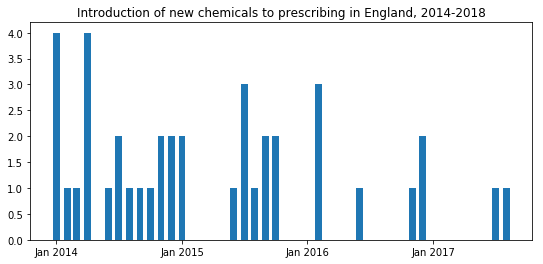

In [30]:
df2 = months.merge(intros, how="left", left_on="month", right_on="month_introduced")[["month","code"]].set_index("month").fillna(0)
import matplotlib.dates as mdates
import matplotlib.pylab as plt
fig, ax = plt.subplots(figsize=(9,4))
ax.bar(df2.index, df2['code'], width=20)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title("Introduction of new chemicals to prescribing in England, 2014-2018")
plt.show()


## Show prescribing rates of each chemical

In [32]:
if not os.path.exists('new_chemicals_prescribing.csv'):
    sql = """
    SELECT
      month,
      chemical,
      SUBSTR(bnf_code, 1, 9) AS chemical_code,
      SUM(items) AS items
    FROM
      `ebmdatalab.hscic.normalised_prescribing_standard` rx
    INNER JOIN
      `ebmdatalab.hscic.bnf` AS bnf
    ON SUBSTR(rx.bnf_code, 1, 9) = bnf.chemical_code
    WHERE
      ({})
    GROUP BY
      month,
      chemical,
      chemical_code
    ORDER BY
      month, chemical
    """
    where = []
    for chemical in df.code:
        where.append("bnf_code LIKE '{}%'".format(chemical))
    where = " OR ".join(where)
    df2 = pd.read_gbq(sql.format(where), 'ebmdatalab', verbose=False, dialect='standard').set_index('month')
    df2.to_csv("new_chemicals_prescribing.csv")
else:
    df2 = pd.read_csv("new_chemicals_prescribing.csv")
    df2['month'] = pd.to_datetime(df2['month'])

Text(0, 0.5, 'Items')

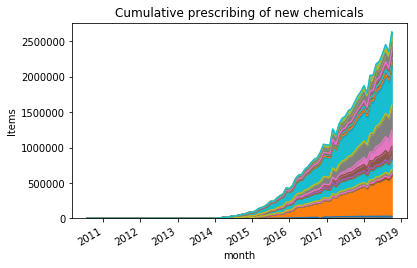

In [36]:
df3 = df2.reset_index().set_index(['chemical','month']).unstack('chemical')['items']
ax = df3.plot(kind='area',stacked=True,legend=False, title="Cumulative prescribing of new chemicals")
ax.set_ylabel("Items")

## Counting new drugs for first 6 months after introduction only

In [144]:
from pandas.tseries.offsets import *

sql_template = """SELECT
      month,
      chemical,
      SUBSTR(bnf_code, 1, 9) AS chemical_code,
      SUM(items) AS items
    FROM
      `ebmdatalab.hscic.normalised_prescribing_standard` rx
    INNER JOIN
      `ebmdatalab.hscic.bnf` AS bnf
    ON SUBSTR(rx.bnf_code, 1, 9) = bnf.chemical_code
    WHERE
      bnf_code LIKE '{}%' AND month >= "{}" AND month <= "{}"
    GROUP BY
      month,
      chemical,
      chemical_code"""
sql = []
for index, row in df.iterrows():
    start_date = row['month_introduced']
    code = row['code']
    sql.append(sql_template.format(code, start_date, start_date + DateOffset(months=6) ))
df3 = pd.read_gbq(" UNION ALL ".join(sql), 'ebmdatalab', verbose=False, dialect='standard')

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


In [ ]:
df4 = df3.reset_index().set_index(['chemical','month']).unstack('chemical')['items']
df4.plot(kind='area',stacked=False,legend=False)

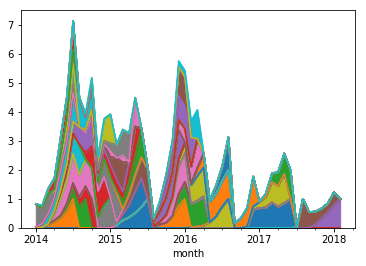

In [146]:
# make everything a ratio of what it was at 12 months
# we just want to do a count of new drugs in any given month pre practice.
# If we assume maximum adoption at month N (e.g. 12)
# then we want a measure of a "quick adopter", which could be "adopts a drug within 6 months"
# which is like a moving average?
# Or just 

df5 = pd.DataFrame(index=df4.index)
for column in df4.columns:
    df5[column] = df4[column] / df4[column].max()
df5.plot(kind='area',stacked=True,legend=False)

# Attempt a measure of "noveltiness"

For every new chemical, count the number of items prescribed per-CCG at 12 months following its introduction, and express that per patient.  Items with a high score tend to prescribe the most novel chemicals.

This is very naive and needs more work as the vast majority of this is likely to be accounted for by one or two blockbuster drugs. If we really want novelty we should do this per-chemical and express as a proportion of the maximum uptake.




In [40]:
from pandas.tseries.offsets import *

sql_template = """SELECT
      rx.month,
      rx.practice,
      pct,
      count(items) AS novel_items,
      total_list_size
    FROM
      `ebmdatalab.hscic.normalised_prescribing_standard` rx
    INNER JOIN
      `ebmdatalab.hscic.practice_statistics` stats
    ON stats.practice = rx.practice AND stats.month = rx.month
    WHERE
      {}
    GROUP BY
      rx.month,
      rx.practice, pct, total_list_size"""
where = []
where_template = "(bnf_code LIKE '{}%' AND rx.month = '{}')"
for index, row in df.iterrows():
    start_date = row['month_introduced']
    code = row['code']
    where.append(where_template.format(code, start_date + DateOffset(months=12)))
where = " OR ".join(where)
df6 = pd.read_gbq(sql_template.format(where), 'ebmdatalab', verbose=False, dialect='standard')

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/io/gbq.py:108: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs)


In [43]:
df6 = df6[df6['total_list_size']> 0]
df6['x'] = (df6['novel_items']  / df6['total_list_size']) 
df6.sort_values('x', ascending=False)
df6.groupby('pct').sum().reset_index().sort_values('x', ascending=False).head(10)

,pct,novel_items,total_list_size,x
189,99J,367,2641110,1.050665
178,15C,583,5165335,0.441008
180,15E,628,5140133,0.108057
181,15F,520,4126628,0.075390
152,09W,346,1671880,0.074635
175,14L,432,2730432,0.074276
169,11M,486,3358633,0.067433
83,05L,322,1973685,0.065038
53,03N,398,2498569,0.064987
182,99A,291,1772368,0.064041


# Plots of individual chemical uptake

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


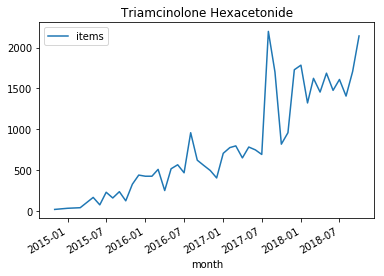

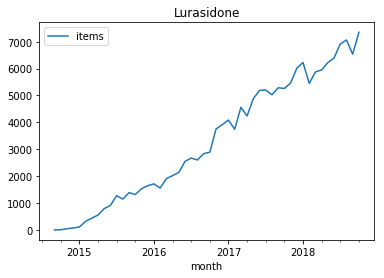

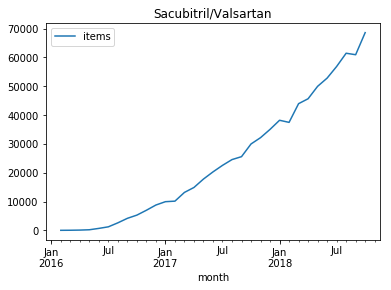

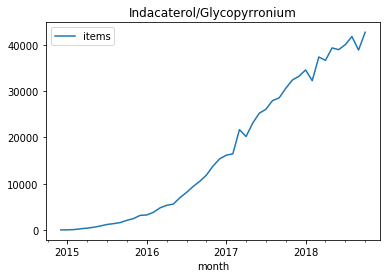

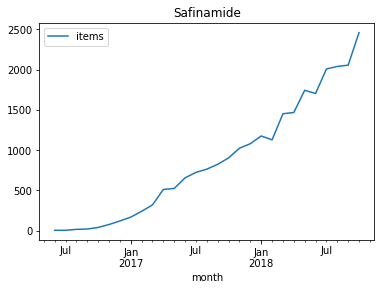

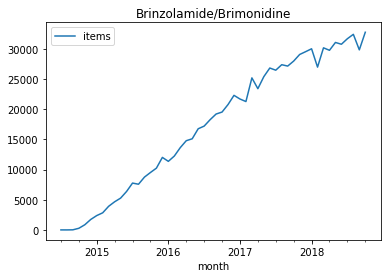

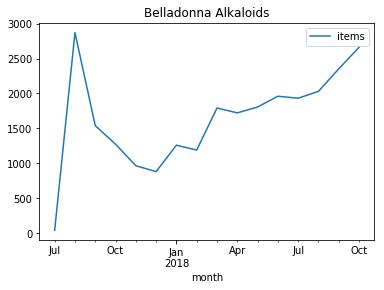

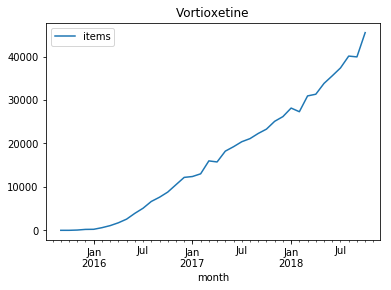

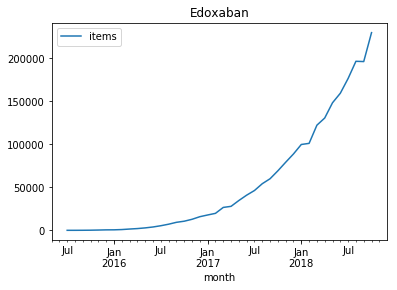

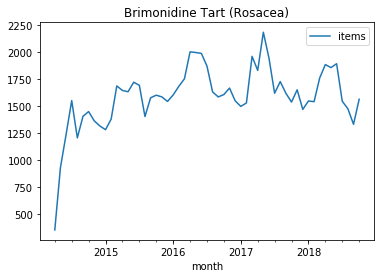

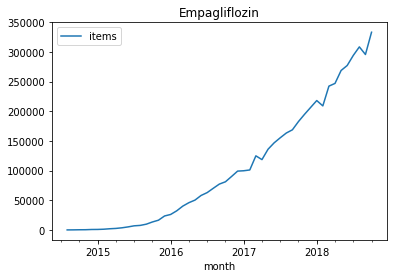

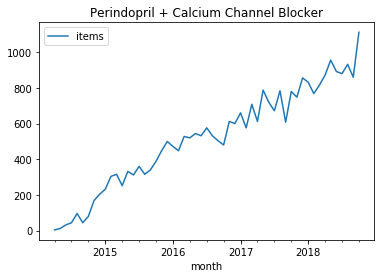

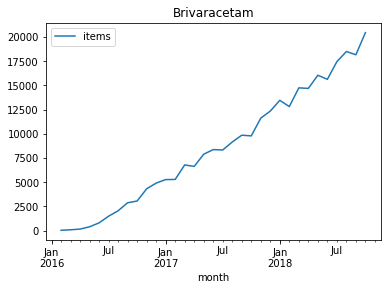

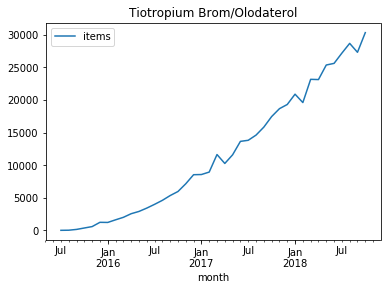

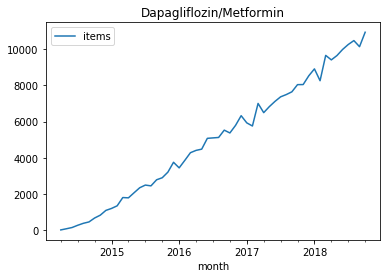

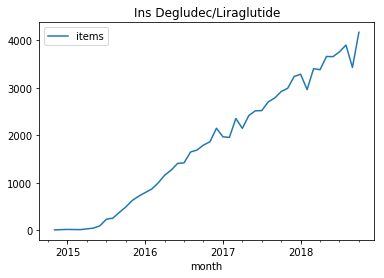

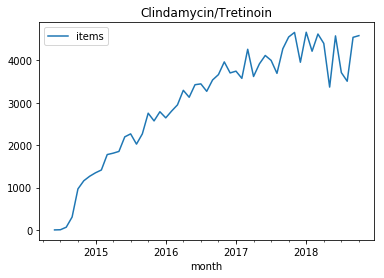

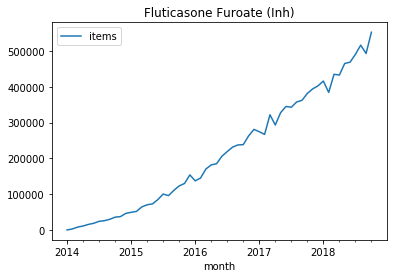

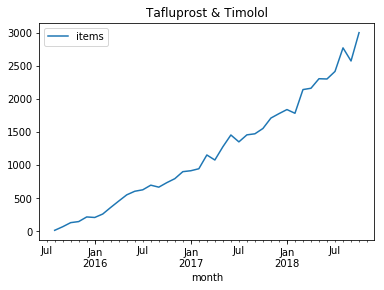

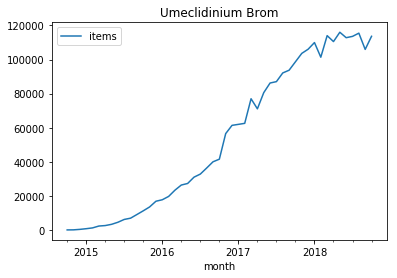

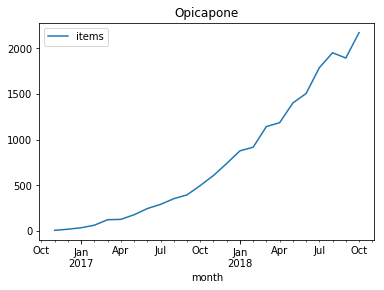

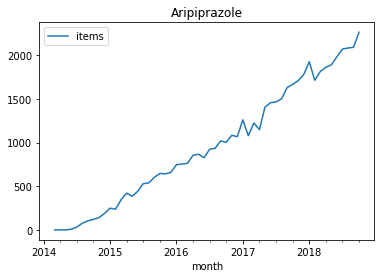

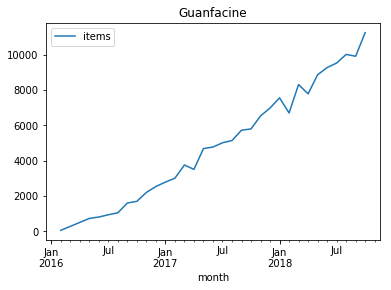

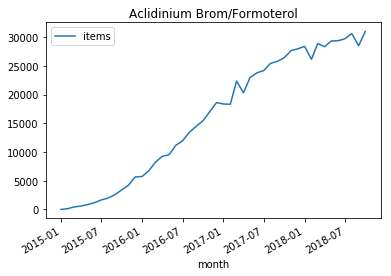

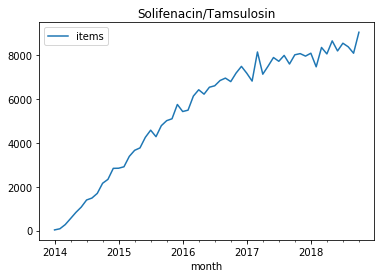

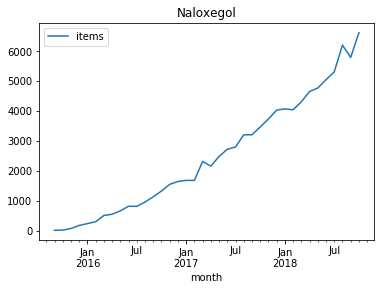

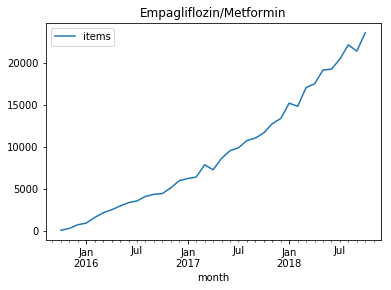

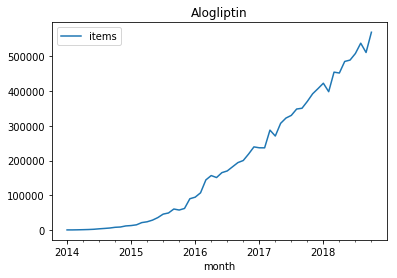

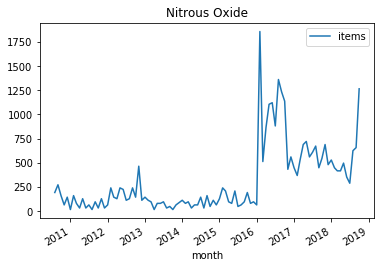

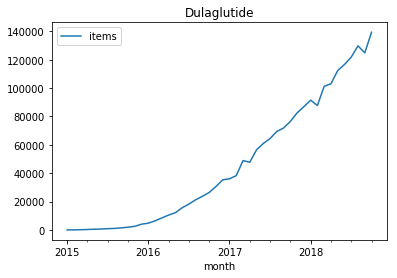

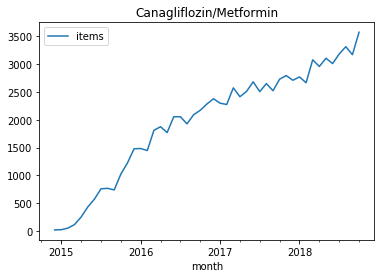

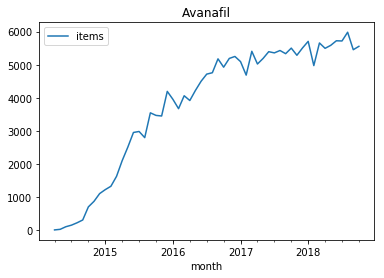

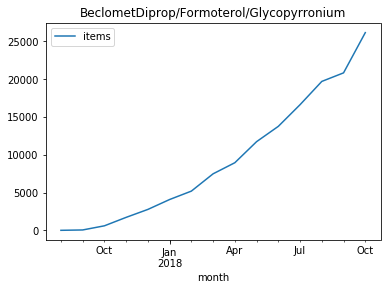

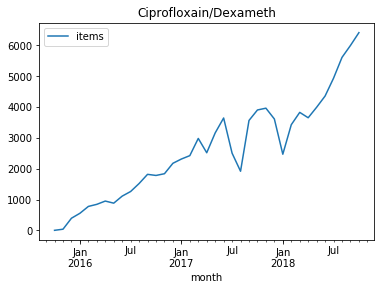

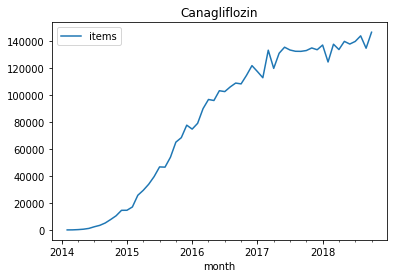

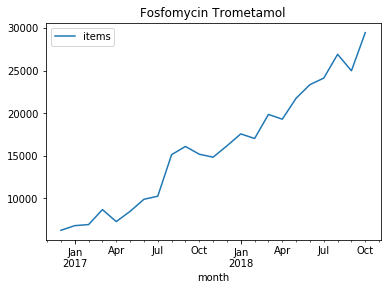

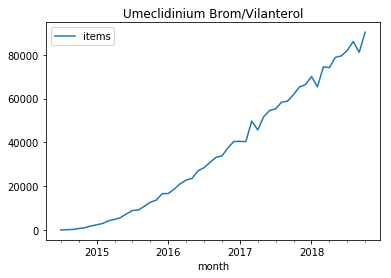

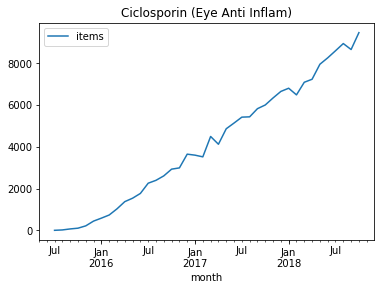

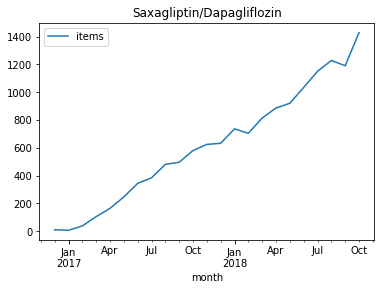

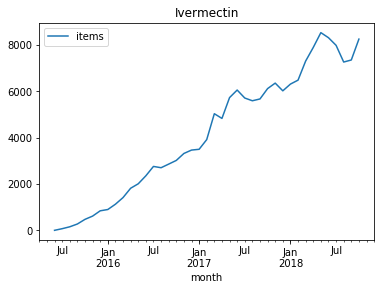

In [16]:
for chemical_code in df.code:
    title = df2[df2['chemical_code'] == chemical_code]['chemical'].iloc[0]
    df2[df2['chemical_code'] == chemical_code].plot(title=title)